In [163]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, roc_curve, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import cv2

Константы

In [110]:
IMAGE_SIZE = (150, 150)
IMAGE_SHAPE = (-1, 150, 150, 1)
THRESHOLD = 0.7

In [41]:
train_path = '../dataset/chest_xray/train'
val_path = '../dataset/chest_xray/val'
test_path = '../dataset/chest_xray/test'

In [42]:
labels = ['PNEUMONIA', 'NORMAL']

In [43]:
def check_extensions(dir: str) -> None:
    """
    Выводит расширения файлов в директории

    :param dir: путь директории
    """
    for label in labels:
        path = os.path.join(dir, label)
        files = os.listdir(path)
        extensions = set()
        for file in files:
            extensions.add(file.split(".")[-1])
        print(extensions)

In [44]:
c = [train_path, val_path, test_path]
for path in c:
    print(path)
    check_extensions(path)

../dataset/chest_xray/train
{'DS_Store', 'jpeg'}
{'DS_Store', 'jpeg'}
../dataset/chest_xray/val
{'DS_Store', 'jpeg'}
{'DS_Store', 'jpeg'}
../dataset/chest_xray/test
{'jpeg'}
{'jpeg'}


In [45]:
def dataset_from_dir(data_dir: str) -> tuple[np.ndarray]:
    """
    Считавает датасет изображений из указанной директории

    :param data_dir: директория с данными
    :return (image_array, classes): массив с изображениями и массив с классами
    :rtype (ndarray, ndarray): кортеж массивов numpy
    """
    image_array = []
    classes = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            if ".jpeg" not in img:
                continue
            image = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            resized_img = cv2.resize(image, IMAGE_SIZE)
            image_array.append(resized_img)
            classes.append(class_num)
    return np.array(image_array), np.array(classes)

In [137]:
x_train, y_train = dataset_from_dir(train_path)
x_test, y_test = dataset_from_dir(test_path)
x_val, y_val = dataset_from_dir(val_path)

Функции визуализации

In [64]:
def pie_plot(data: list | tuple, labels: list | tuple, title: str):
    """
    Рисует круговую диаграмму

    :param data: числовые данные для графика
    :param labels: метки для данных
    :param title: название графика
    """
    plt.pie(data, labels=labels)
    plt.title(title)
    plt.show()

In [67]:
def score_plot(data: list | tuple, labels: list | tuple, title: str, color: list | tuple):
    """
    Рисует столбчатую диаграмму

    :param data: числовые данные для графика
    :param labels: метки для данных
    :param title: название графика
    :param color: цвета столбцов
    """
    plt.bar(labels, data, color=color)
    plt.title(title)
    plt.show()

In [157]:
def roc_auc(data: list, predicted: list):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds = roc_curve(data, predicted, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC')
    #plt.savefig("ROC.png")
    plt.show()

In [138]:
pneumo = 0
norm = 0
for i in y_train:
    if(i == 0):
        pneumo += 1
    else:
        norm += 1

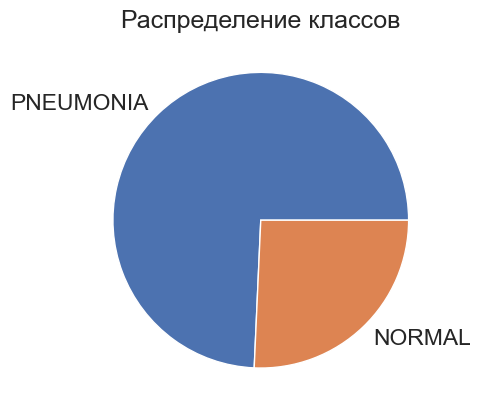

In [139]:
pie_plot((pneumo, norm), labels=labels, title="Распределение классов")

Нормализация датасета

In [140]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

Добавляем цветовой канал

In [141]:
x_train = np.expand_dims(x_train, axis=3)
x_val = np.expand_dims(x_val, axis=3)
x_test = np.expand_dims(x_test, axis=3)

Аугментация

In [142]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range = 30,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        vertical_flip=False)

In [143]:
datagen.fit(x_train)

Создание модели

In [74]:
model = Sequential([
    Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    Dropout(0.1),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    Flatten(),
    Dense(units = 128 , activation = 'relu'),
    Dropout(0.2),
    Dense(units = 1 , activation = 'sigmoid'),
])

Компиляция модели

In [75]:
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

Корректировка скорости обучения

In [76]:
lr = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=True, factor=0.3, min_lr=0.000001)

Обучение

In [77]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32), epochs = 12 , validation_data = datagen.flow(x_val, y_val), callbacks = [lr])

Epoch 1/12
163/163 [==============================] - 321s 2s/step - loss: 0.5635 - accuracy: 0.8242 - val_loss: 57.0746 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 316s 2s/step - loss: 0.2979 - accuracy: 0.8930 - val_loss: 47.1729 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2354 - accuracy: 0.9109
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 315s 2s/step - loss: 0.2354 - accuracy: 0.9109 - val_loss: 101.6086 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 317s 2s/step - loss: 0.1582 - accuracy: 0.9490 - val_loss: 5.7512 - val_accuracy: 0.5625 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - 315s 2s/step - loss: 0.1374 - accuracy: 0.9494 - val_loss: 14.9636 - val_accuracy: 0.5625 - lr: 3.0000e-04
Epoch 6/12
163/163 [==========================

In [78]:
train_acc = model.evaluate(x_train,y_train)[1]
test_acc = model.evaluate(x_test,y_test)[1]

20/20 [==============================] - 15s 740ms/step - loss: 0.2715 - accuracy: 0.9087


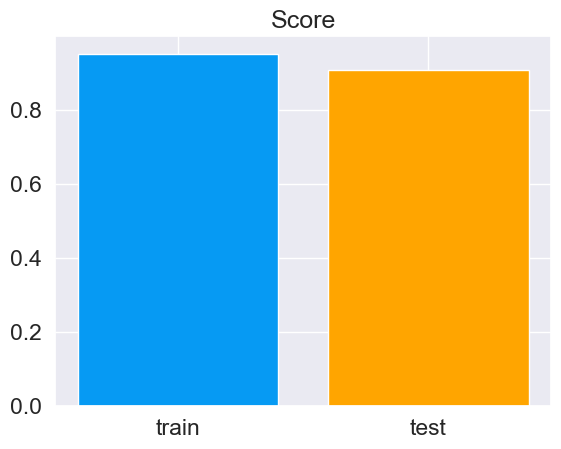

In [144]:
score_plot((train_acc, test_acc), ('train', 'test'), title="Score", color=('#069AF3', 'orange'))

In [145]:
train_predictions = model.predict(x_train)
train_predictions = train_predictions.reshape(1,-1)[0]

163/163 [==============================] - 78s 481ms/step


In [146]:
test_predictions = model.predict(x_test)
test_predictions = test_predictions.reshape(1,-1)[0]

20/20 [==============================] - 9s 444ms/step


ROC AUC

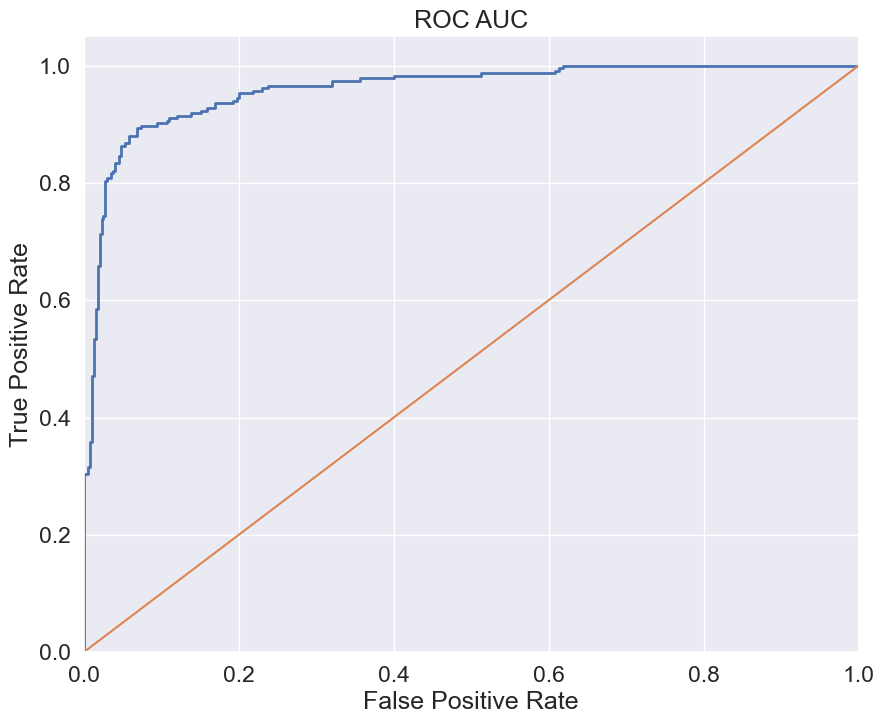

In [158]:
roc_auc(y_test, test_predictions)

In [159]:
train_pred = np.where(train_predictions > THRESHOLD, 1, 0)
test_pred = np.where(test_predictions > THRESHOLD, 1, 0)

Precision, recall, f1

In [160]:
print(classification_report(y_test, test_pred, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.82      0.98      0.89       390
   Normal (Class 1)       0.96      0.64      0.77       234

           accuracy                           0.85       624
          macro avg       0.89      0.81      0.83       624
       weighted avg       0.87      0.85      0.85       624



Confusion matrix

<AxesSubplot: >

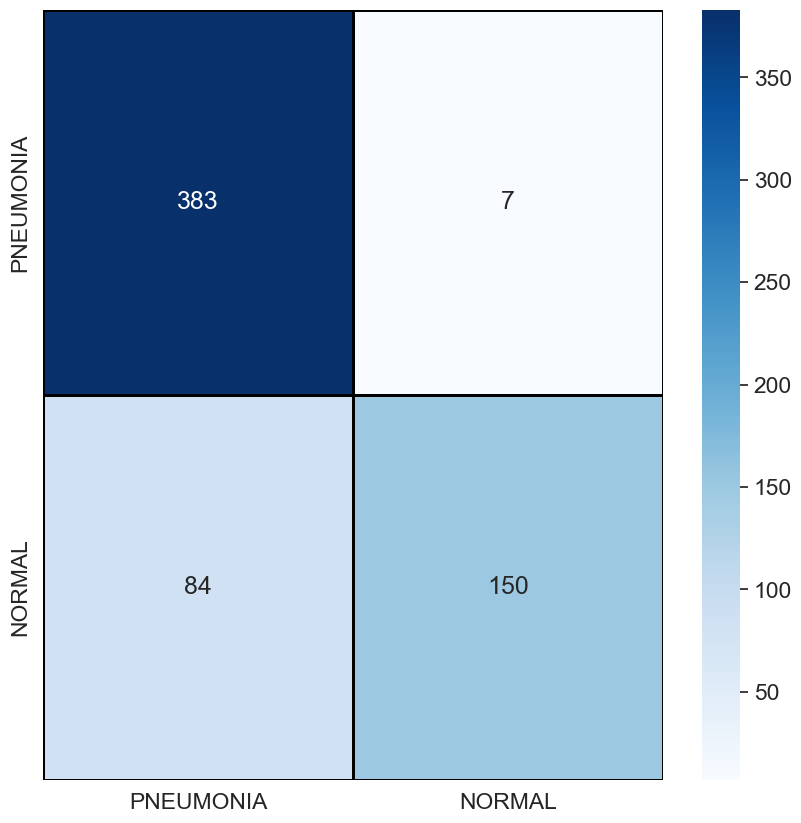

In [166]:
cm = confusion_matrix(y_test, test_pred)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

Сохранение модели

In [78]:
test_score = int(round(test_acc, 2) * 100)

model.save(f"../models/cnn{test_score}.h5")